<a href="https://colab.research.google.com/github/viniciusrpb/cloud_image_classification/blob/main/cloud_classification_ccsn_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloud Image Classification using Vision Transformers

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!cp -r "/content/drive/My Drive/img_satelite/classificacao/CCSN_08/train" "training"
#!cp -r "/content/drive/My Drive/img_satelite/classificacao/CCSN_08/val" "validation"
#!cp -r "/content/drive/My Drive/img_satelite/classificacao/CCSN_08/test" "testing"

In [3]:
#!pip install pytorch pytorch torchvision
#!pip install timm==0.3.2
#!pip install datasets transformers
#!pip install transformers pytorch-lightning --quiet
#!sudo apt -qq install git-lfs

In [4]:
from datasets import load_dataset
import tensorflow as tf
import torchvision
from torchvision.transforms import ToTensor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import Trainer,ViTFeatureExtractor,ViTForImageClassification,DeiTForImageClassification,BeitForImageClassification,DeiTFeatureExtractor,  BeitFeatureExtractor
from pytorch_lightning.callbacks import ModelCheckpoint

In [5]:
path_train = 'training'
path_validation = 'validation'
path_test = 'testing'

Define the image generator objects

In [6]:
train_ds = torchvision.datasets.ImageFolder(path_train, transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder(path_validation, transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder(path_test, transform=ToTensor())

In [7]:
train_ds.classes

['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']

In [8]:
def fn_collator(batch):
    encodings = feature_extractor([x[0] for x in batch], return_tensors='pt')
    encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
    return encodings 

Pega os códigos das classes do dataset

In [9]:
dic_label2id = {}
dic_id2label = {}
for i, class_name in enumerate(train_ds.classes):
  dic_label2id[class_name] = str(i)
  dic_id2label[str(i)] = class_name

Allocate objects for loading the data using the DataGenerator

In [10]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)


In [11]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy","f1-score")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [12]:
from transformers import ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(train_ds.classes),
    id2label=dic_id2label,
    label2id=dic_label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-clouds",
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=7,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=6,
  learning_rate=3e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=fn_collator,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [15]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2030
  Num Epochs = 7
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1778


Step,Training Loss,Validation Loss,Accuracy
100,2.002100,2.031668,0.384000
200,1.857800,1.767668,0.464000
300,1.748200,1.613811,0.508000
400,1.525900,1.525188,0.516000
500,1.460300,1.453383,0.556000
600,1.168400,1.418753,0.548000
700,1.374300,1.361284,0.600000
800,0.875000,1.332804,0.572000
900,0.873200,1.354777,0.556000
1000,1.008300,1.294694,0.556000


***** Running Evaluation *****
  Num examples = 250
  Batch size = 8
Saving model checkpoint to ./vit-base-clouds/checkpoint-100
Configuration saved in ./vit-base-clouds/checkpoint-100/config.json
Model weights saved in ./vit-base-clouds/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-base-clouds/checkpoint-100/preprocessor_config.json
Deleting older checkpoint [vit-base-clouds/checkpoint-700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 250
  Batch size = 8
Saving model checkpoint to ./vit-base-clouds/checkpoint-200
Configuration saved in ./vit-base-clouds/checkpoint-200/config.json
Model weights saved in ./vit-base-clouds/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-base-clouds/checkpoint-200/preprocessor_config.json
Deleting older checkpoint [vit-base-clouds/checkpoint-800] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 250
  Batch size = 8
Saving model checkpoint to ./vit-base-cloud

***** train metrics *****
  epoch                    =          7.0
  total_flos               = 1025618982GF
  train_loss               =       1.0588
  train_runtime            =   0:09:09.47
  train_samples_per_second =       25.861
  train_steps_per_second   =        3.236


In [16]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 263
  Batch size = 8


***** eval metrics *****
  epoch                   =        7.0
  eval_accuracy           =     0.5932
  eval_loss               =     1.3058
  eval_runtime            = 0:00:05.74
  eval_samples_per_second =      45.79
  eval_steps_per_second   =      5.746


***** Running Prediction *****
  Num examples = 263
  Batch size = 8


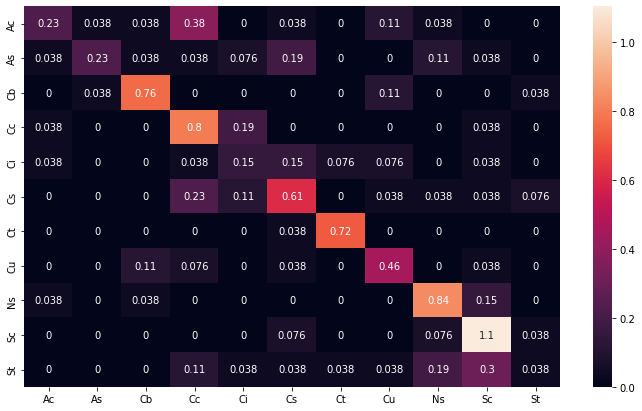

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

testloader = torch.utils.data.DataLoader(test_ds, batch_size=16,
                                        shuffle=False, num_workers=2)

predictions = trainer.predict(test_ds)

y_prob = predictions[0]

y_pred = np.argmax(y_prob,axis=1)

labels = np.array(predictions.label_ids)
y_true.extend(labels)
     
classes = tuple(test_ds.classes)#('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        #'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
z = confusion_matrix(y_true, y_pred)
z

array([[ 6,  1,  1, 10,  0,  1,  0,  3,  1,  0,  0],
       [ 1,  6,  1,  1,  2,  5,  0,  0,  3,  1,  0],
       [ 0,  1, 20,  0,  0,  0,  0,  3,  0,  0,  1],
       [ 1,  0,  0, 21,  5,  0,  0,  0,  0,  1,  0],
       [ 1,  0,  0,  1,  4,  4,  2,  2,  0,  1,  0],
       [ 0,  0,  0,  6,  3, 16,  0,  1,  1,  1,  2],
       [ 0,  0,  0,  0,  0,  1, 19,  0,  0,  0,  0],
       [ 0,  0,  3,  2,  0,  1,  0, 12,  0,  1,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  0, 22,  4,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0,  2, 29,  1],
       [ 0,  0,  0,  3,  1,  1,  1,  1,  5,  8,  1]])

In [19]:
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

          Ac       0.60      0.26      0.36        23
          As       0.75      0.30      0.43        20
          Cb       0.77      0.80      0.78        25
          Cc       0.48      0.75      0.58        28
          Ci       0.27      0.27      0.27        15
          Cs       0.52      0.53      0.52        30
          Ct       0.86      0.95      0.90        20
          Cu       0.55      0.63      0.59        19
          Ns       0.65      0.79      0.71        28
          Sc       0.63      0.85      0.72        34
          St       0.20      0.05      0.08        21

    accuracy                           0.59       263
   macro avg       0.57      0.56      0.54       263
weighted avg       0.58      0.59      0.56       263

